<a href="https://colab.research.google.com/github/condusinew/vaccine_failure_escape/blob/main/seed_natimm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

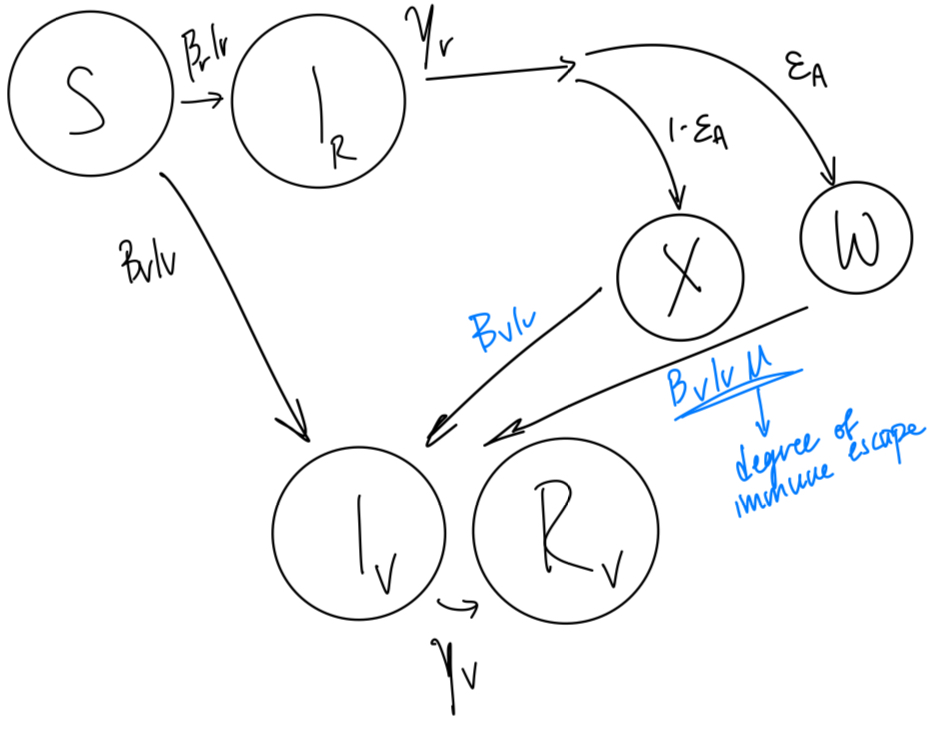

$\frac{\mathrm{d}S}{\mathrm{d}t} = -(\beta_r I_r + \beta_v I_v)S$

$\frac{\mathrm{d}I_r}{\mathrm{d}t} = \beta_r I_r [S+N+(1-\epsilon_L) P] - \gamma_r I_r $

$\frac{\mathrm{d}N}{\mathrm{d}t} = (1-\epsilon_a)\gamma_rI_r - (\beta_v I_v + \beta_r I_r) N $

$\frac{\mathrm{d}P}{\mathrm{d}t} = \epsilon_a\gamma_rI_r - \beta_r I_r(1-\epsilon_L)P - \beta_v I_v (1-(1-\mu)\epsilon_L) P$

$\frac{\mathrm{d}I_v}{\mathrm{d}t} = \beta_v I_v [S + N + (1-(1-\mu)\epsilon_L)] P - \gamma_v I_v$

$\frac{\mathrm{d}R_v}{\mathrm{d}t} = \gamma_v I_v$

#MUST RUN

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [ ]:
# SIR model equations
def SIR_model_rv(t, y, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
    S, Iw, N, P, Im, Rm, CIw, CIm  = y

    dSdt = -(betaw*Iw+ betam*Im) * S
    dIwdt = betaw * Iw* (S + N + (1-epsilonL)*P)  - gammaw * Iw

    dNdt = (1-epsilona)*gammaw * Iw - (betam*Im+betaw*Iw) *N
    dPdt = epsilona * gammaw * Iw-betaw*Iw*(1-epsilonL)*P - betam*Im*(1-((1-mu)*epsilonL))*P

    dImdt = betam*Im*(S + N +(1-((1-mu)*epsilonL))*P) - gammam * Im
    dRmdt = gammam * Im

    dCIwdt = betaw * Iw* (S + N + (1-epsilonL)*P)
    dCImdt = betam*Im*(S + N +(1-((1-mu)*epsilonL))*P)

    return [dSdt, dIwdt, dNdt, dPdt, dImdt, dRmdt, dCIwdt, dCImdt]


In [ ]:
#ALWAYS RUN
CIm0 = 0
CIw0 = 0

In [ ]:

# basic plot to show compartment prevalence across time
def plot_basic(solution, ax=None, title="SIR sim w variant", ylim_max = 1):
    if ax is None:
        fig, ax = plt.subplots()

    t = solution.t
    S, Iw, N, P, Im, Rm, CIw, CIm = solution.y

    ax.plot(t, S, label='Susceptible')
    ax.plot(t, Iw, label='Infected (wildtype)')
    ax.plot(t, Im, label='Infected (mutant)')
    ax.plot(t, Rm, label='Recovered (mutant)')
    ax.plot(t, N, label='Immunity_none')
    ax.plot(t, P, label='Immunity_leaky')

    ax.set_xlabel('Time (days)')
    ax.set_ylabel('Proportion of Population')
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax

def plot_cum(solution, ax=None, title="Cumulative infections", ylim_max = 1):
    if ax is None:
        fig, ax = plt.subplots()

    t = solution.t
    *_, CIw, CIm = solution.y

    ax.plot(t, CIw, label="Cumulative WT")
    ax.plot(t, CIm, label="Cumulative variant")

    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Cumulative incidence")
    ax.set_title(title)
    ax.set_ylim(0, ylim_max)
    ax.legend()
    ax.grid(True)

    return ax


#find final cumulative infections (gonna multiply this for total infected)
def find_finalCIw(solution):
  t = solution.t
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y
  return(CIw[-1])

def find_finalCIm(solution):
  t = solution.t
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y
  return(CIm[-1])

#find whether it is a one wave epidemic or endemic equil
def Iw_wave_or_end(solution):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y

  if Iw[-1] > 0.02: #MAYBE CHANGE THIS IF NEEDED DEPENDING ON WHAT GRAPHS SHOW
    return "endemic"

  else:
    return "wave"

def find_Iw_peak(solution, wave_or_end: str):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y

  if wave_or_end == "wave":
    return max(Iw)

  else:
    return pd.NA

def find_Iw_equil(solution, wave_or_end: str):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y

  if wave_or_end == "endemic":
    return Iw[-1]

  else:
    return pd.NA

def Im_wave_or_end(solution):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y

  if Iw[-1] > 0.02: #MAYBE CHANGE THIS IF NEEDED DEPENDING ON WHAT GRAPHS SHOW
    return "endemic"

  else:
    return "wave"

def find_Im_peak(solution, wave_or_end: str):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y

  if wave_or_end == "wave":
    return max(Im)

  else:
    return pd.NA

def find_Im_equil(solution, wave_or_end: str):
  S, Iw, N, P, Im, Rm, CIw, CIm  = solution.y

  if wave_or_end == "endemic":
    return Im[-1]

  else:
    return pd.NA


In [ ]:
#plotting functions


#function for plotting any two compartment curves (eg. Iw) for many scenarios, with only one (hence mono) specified param (eg. mu) being modulated
def plot_many_mono_anytwo(param, compartment1 = "Iw", compartment2 = "Im", figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with (param val) as as keysn, values being solutions

  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)
  ax2 = fig.add_subplot(122, axisbelow=True)

  for key, solution in kwargs.items():
    S, Iw, N, P, Im, Rm, CIw, CIm =  solution.y #takes solution out from list
    t = solution.t

    curves = {
            "S": S,
            "Iw": Iw,
            "N": N,
            "P": P,
            "Im": Im,
            "Rm": Rm
        }

    label = f"{param} = {key}"
    ax1.plot(t, curves[compartment1], label=label, alpha=0.5)
    ax2.plot(t, curves[compartment2], label=label, alpha=0.5)

  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel((f"{compartment1}"))
  ax1.set_ylim(0,ylim_max)
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)

  ax2.set_xlabel('Time (days)')
  ax2.set_ylabel(f"{compartment2}")
  ax2.set_ylim(0,ylim_max)
  ax2.grid(linewidth=0.5)
  legend = ax2.legend()
  legend.get_frame().set_alpha(0.5)


#function for plotting ONE compartment curves (eg. Iw) for many scenarios, with only one (hence mono) specified param (eg. mu) being modulated
def plot_many_mono_one(param: str, compartment: str, figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with (param val) as as keysn, values being solutions
    fig= plt.figure(facecolor="w", figsize=figsize)
    ax1 = fig.add_subplot(121, axisbelow=True)

    for key, solution in kwargs.items():
        S, Iw, N, P, Im, Rm, CIw, CIm =  solution.y
        t = solution.t

        curves = {
            "S": S,
            "Iw": Iw,
            "N": N,
            "P": P,
            "Im": Im,
            "Rm": Rm
        }

        label = f"{param} = {key}"
        ax1.plot(t, curves[compartment], label=label, alpha=0.5)

    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel(f"{compartment}")
    ax1.set_ylim(0, ylim_max)
    ax1.grid(linewidth=0.5)
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)

    plt.show()



#SIMILAR TO ABOVE PLOTS BUT FOR RELATImE FREQUENCY ONLY

#function for plotting infected for many epsilons
def plot_many_Mprop(figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with epsilon_a as as keys, values being a list of epsilon_l and solution

  fig = plt.figure(facecolor="w", figsize=figsize)

  #resident subplot
  ax1 = fig.add_subplot(121, axisbelow=True)

  for epsilon_a, eps_solut in kwargs.items():
    S, Iw, N, P, Im, Rm, CIw, CIm =  eps_solut[1].y #takes solution (index 1) out from list
    t = eps_solut[1].t

    M_prop = Im/(Iw+Im)
    label = "epsilon_a = " + epsilon_a + ", epsilon_L = " + eps_solut[0]
    ax1.plot(t, M_prop, label=label, alpha=0.5)


  ax1.set_xlabel('Time (days)')
  ax1.set_ylabel('Im/Iw')
  ax1.set_ylim(0,ylim_max)
  ax1.grid(linewidth=0.5)
  legend = ax1.legend()
  legend.get_frame().set_alpha(0.5)


def plot_many_mono_Mprop(param: str, figsize=(15, 6), ylim_max = 1, **kwargs):
  #must send kwargs as a dictionary with (param val) as as keysn, values being solutions
    fig = plt.figure(facecolor="w", figsize=figsize)
    ax1 = fig.add_subplot(121, axisbelow=True)

    for key, solution in kwargs.items():
        S, Iw, N, P, Im, Rm, CIw, CIm =  solution.y

        t = solution.t

        M_prop = Im/(Iw+Im)

        label = f"{param} = {key}"
        ax1.plot(t, M_prop, label=label, alpha=0.5)

    ax1.set_xlabel("Time (days)")
    ax1.set_ylabel("Im/Iw")
    ax1.set_ylim(-0.1, ylim_max)
    ax1.grid(linewidth=0.5)
    legend = ax1.legend()
    legend.get_frame().set_alpha(0.5)

    plt.show()

#Stress-Testing scenarios

1. Basic SIR model with perfect natural immunity only
P as the absorbing compartment. Behaviour should resemble SIR model, with P as traditional R. Final epidemic size is affected by R0. If R0 is kept constant, changes in recovery should not change final epidemic size. Rate of increase of epidemic (as seen in P and Iw) is influenced by beta and indIwectly affected by R0 and recovery rate.

In [ ]:
# set parameter values
#betaw = 1.1
Rwnaught = 1.6
gammaw = 1/14
betaw = gammaw*Rwnaught

#Rwnaught = betaw / gammaw # R0 for residents with entIwely susceptible population


betam = 1
gammam = 1
Rmnaught = betam / gammam # R0 for variant with entIwely susceptible population

mu = 0.6
epsilona = 1
epsilonL = 1
t = 500

# set initial conditions
S0 = 0.999
Iw0 = 0.001

N0 = 0
P0 = 0

Rm0 = 0
Im0 = 1-(S0+Iw0+N0+P0+Rm0) #need to get this seeded later

if (S0+Iw0+Im0+Rm0+N0+P0) != 1 or Im0 < 0:
  print("Parameters don't add up to 1 or there are negatIme parameter values")

y0 = [S0, Iw0, N0, P0, Im0, Rm0, CIw0, CIm0]

In [ ]:
#FUNCTION TO FIND TIME OF VARIANT RISING

def find_tv(recovered_threshold = 0.1):
  # run sir model (with no variant) until R = 0.1
  def _reach_size(t, y, mu, betaw, gammaw, betam, gammam, epsilona, epsilonL):
      return (y[2]+y[3]+y[4]) - recovered_threshold

  _reach_size.terminate = True

  # RUN BEFORE SEEDING
  # RUN WHEN Iv = 0, to find time of variant see
  sol_findtv = solve_ivp(SIR_model_rv, [0,t], y0,
                  args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
                  events=_reach_size, t_eval = np.linspace(0, t, t)) #changed dense output to np.linspace

  # get tv and seed Iv
  tv = np.ravel(np.array(sol_findtv.t_events))[0]

  return tv

tv = find_tv(recovered_threshold = 0.1)



In [ ]:
tv

np.float64(100.94992025976705)

In [ ]:
#do solution up to tv
sol1 = solve_ivp(SIR_model_rv, [0,tv], y0,
                 args=(mu, betaw, gammaw, betaw, gammaw, epsilona, epsilonL),
                 t_eval = np.linspace(0, tv, t))

y_tv = sol1.y[:, -1]

proportionX = y_tv[2]/(y_tv[2]+y_tv[3])
proportionW = 1-proportionX

y_tv[2] -= 0.01*proportionX   # seed small fraction into Iv
y_tv[3] -= 0.01*proportionW
y_tv[4] = 0.01




In [ ]:
sol2 = solve_ivp(
    SIR_model_rv,
    [tv, t], # start at tv
    y_tv, # use updated initial condition
    args=(mu, betaw, gammaw, betam, gammam, epsilona, epsilonL),
    t_eval = np.linspace(tv, t, t)
)

print(y_tv)

[0.85105156 0.04879123 0.         0.09015721 0.01       0.
 0.14794844 0.        ]


In [ ]:
sol2.y[4]

array([ 1.00000000e-02,  9.23627287e-03,  8.47303910e-03,  7.72371490e-03,
        6.99872745e-03,  6.30653541e-03,  5.65362906e-03,  5.04453020e-03,
        4.48179223e-03,  3.96579293e-03,  3.49492407e-03,  3.06821572e-03,
        2.68434705e-03,  2.34150036e-03,  2.03736109e-03,  1.76911775e-03,
        1.53346203e-03,  1.32658869e-03,  1.14422144e-03,  9.83536422e-04,
        8.43200297e-04,  7.21526696e-04,  6.16701928e-04,  5.26784975e-04,
        4.49707498e-04,  3.83273831e-04,  3.25347207e-04,  2.75195060e-04,
        2.32273461e-04,  1.95896400e-04,  1.65301768e-04,  1.39651348e-04,
        1.18030821e-04,  9.94497656e-05,  8.32080543e-05,  6.93157905e-05,
        5.76322357e-05,  4.79643282e-05,  4.00686059e-05,  3.36512067e-05,
        2.83678680e-05,  2.38239270e-05,  1.97044637e-05,  1.61217055e-05,
        1.31096647e-05,  1.06631937e-05,  8.74747803e-06,  7.29803652e-06,
        6.22072110e-06,  5.39171695e-06,  4.65754249e-06,  3.85640292e-06,
        3.06090389e-06,  

In [ ]:
t_full = np.concatenate([sol1.t, sol2.t])
y_full = np.hstack([sol1.y, sol2.y])
S, Iw, N, P, Im, Rm, CIw, CIm  = y_full


In [ ]:
t_full

array([0.00000000e+00, 2.02304449e-01, 4.04608899e-01, 6.06913348e-01,
       8.09217798e-01, 1.01152225e+00, 1.21382670e+00, 1.41613115e+00,
       1.61843560e+00, 1.82074004e+00, 2.02304449e+00, 2.22534894e+00,
       2.42765339e+00, 2.62995784e+00, 2.83226229e+00, 3.03456674e+00,
       3.23687119e+00, 3.43917564e+00, 3.64148009e+00, 3.84378454e+00,
       4.04608899e+00, 4.24839344e+00, 4.45069789e+00, 4.65300234e+00,
       4.85530679e+00, 5.05761124e+00, 5.25991568e+00, 5.46222013e+00,
       5.66452458e+00, 5.86682903e+00, 6.06913348e+00, 6.27143793e+00,
       6.47374238e+00, 6.67604683e+00, 6.87835128e+00, 7.08065573e+00,
       7.28296018e+00, 7.48526463e+00, 7.68756908e+00, 7.88987353e+00,
       8.09217798e+00, 8.29448243e+00, 8.49678688e+00, 8.69909132e+00,
       8.90139577e+00, 9.10370022e+00, 9.30600467e+00, 9.50830912e+00,
       9.71061357e+00, 9.91291802e+00, 1.01152225e+01, 1.03175269e+01,
       1.05198314e+01, 1.07221358e+01, 1.09244403e+01, 1.11267447e+01,
      

In [ ]:
y_full

array([[9.99000000e-01, 9.98976803e-01, 9.98953405e-01, ...,
        3.73907870e-01, 3.73907504e-01, 3.73907156e-01],
       [1.00000000e-03, 1.00868429e-03, 1.01744346e-03, ...,
        6.46625473e-06, 6.31955433e-06, 6.17618189e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.09888606e-02, 7.09892559e-02, 7.09896148e-02],
       [0.00000000e+00, 2.31972674e-05, 4.65954353e-05, ...,
        5.68842902e-01, 5.68843120e-01, 5.68843334e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.09895541e-02, 6.09898336e-02, 6.09900872e-02]])

In [ ]:
plot_basic#NEEDS TO BE FIXED

<function __main__.plot_basic(solution, ax=None, title='SIR sim w variant', ylim_max=1)>

ODEINT VS SOLVE IVP


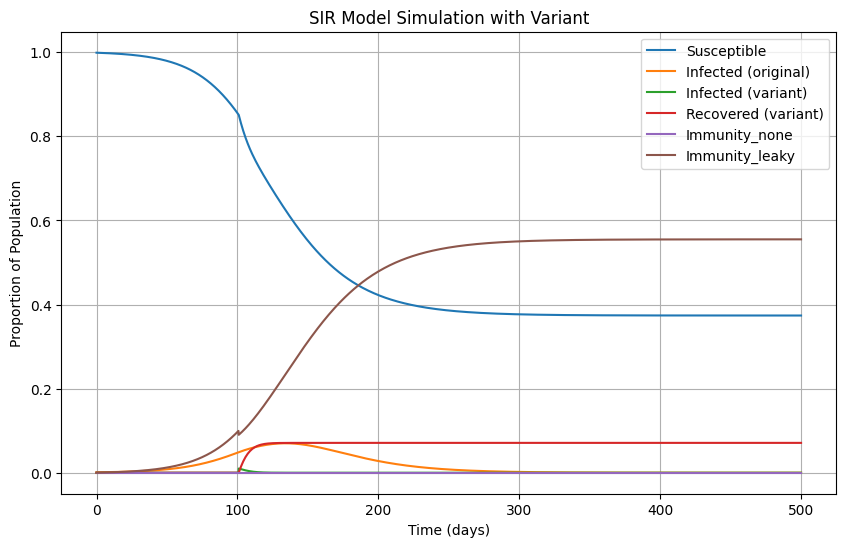

In [ ]:
# Extract time and solution arrays


plt.figure(figsize=(10, 6))

plt.plot(t_full, S, label='Susceptible')
plt.plot(t_full, Iw, label='Infected (original)')

plt.plot(t_full, Im, label='Infected (variant)')

plt.plot(t_full, Rm, label='Recovered (variant)')
plt.plot(t_full, N, label='Immunity_none')
plt.plot(t_full, P, label='Immunity_leaky')


plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIR Model Simulation with Variant')
plt.legend()
plt.grid(True)
plt.show()


# IMMUNITY CONFERRED BY NAT IMMUNITY SHOULD BE ADDRESSING RESIDENT STRAIN
# NEED AN ALL OR NOTHING SCENARIO WITH NOTHINGS THAT ARE RESIDENT AND VARIANT SUSC AND ALL WHICH IS JUST VARIANT SUS
# SHOULD BE COMING FROM INECTED OR SUSCEPTIBLE CLASS MUT


In [ ]:

plt.figure(figsize=(10, 6))


plt.plot(t, Iv, label='Infected (variant)')

plt.plot(t, Rv, label='Recovered (variant)')


plt.xlabel('Time (days)')
plt.ylabel('Proportion of Population')
plt.title('SIR Model Simulation with Variant')
plt.legend()
plt.grid(True)
plt.show()